In [1]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tqdm.pandas()

# Use Panoptic stylesheet. See - https://github.com/panoptic-labs/research/blob/main/stylesheet/panoptic-dark-2_1.mplstyle
plt.style.use('[DIR]/stylesheet/panoptic-dark-16_9.mplstyle')

In [2]:
dir = '[YOUR_DIRECTORY_HERE]'

In [3]:
# Convert data to pandas dataframe
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

# Query Uniswap v3 LP data from subgraph

In [4]:
# This queries the WETH-USDC 30 bps pool

query_initial = gql("""
  query MyQuery {
    positions(where: {liquidity: "0", token0_: {symbol: "USDC"}, token1_: {symbol: "WETH"}, pool_: {feeTier: "3000"}}, first: 1) {
      withdrawnToken0
      withdrawnToken1
      depositedToken0
      depositedToken1
      collectedFeesToken1
      collectedFeesToken0
      id
      liquidity
      tickLower {
        tickIdx
        pool {
          id
        }
        price1
        price0
      }
      tickUpper {
        tickIdx
        price1
        price0
      }
      owner
      transaction {
        blockNumber
        timestamp
        gasPrice
        gasUsed
        id
        burns {
          id
          timestamp
        }
        mints {
          transaction {
            gasUsed
            gasPrice
            id
          }
          id
          timestamp
        }
      }
      token0 {
        id
        symbol
        decimals
      }
      token1 {
        id
        symbol
        decimals
      }
      pool {
        feeTier
      }
    }
  }
""")

In [5]:
# This queries the WETH-USDC 30 bps pool

query = gql("""
  query MyQuery($lastID: String) {
    positions(where: {liquidity: "0", token0_: {symbol: "USDC"}, token1_: {symbol: "WETH"}, pool_: {feeTier: "3000"}, id_gt: $lastID}, first: 100) {
      withdrawnToken0
      withdrawnToken1
      depositedToken0
      depositedToken1
      collectedFeesToken1
      collectedFeesToken0
      id
      liquidity
      tickLower {
        tickIdx
        pool {
          id
        }
        price1
        price0
      }
      tickUpper {
        tickIdx
        price1
        price0
      }
      owner
      transaction {
        blockNumber
        timestamp
        gasPrice
        gasUsed
        id
        burns {
          id
          timestamp
        }
        mints {
          transaction {
            gasUsed
            gasPrice
            id
          }
          id
          timestamp
        }
      }
      token0 {
        id
        symbol
        decimals
      }
      token1 {
        id
        symbol
        decimals
      }
      pool {
        feeTier
      }
    }
  }
""")

In [6]:
# Connects to the Uniswap v3 Ethereum subgraph
client = Client(
 transport=RequestsHTTPTransport(
 url='https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3',
 verify=True,
 retries=5,
 ))


all_results = []
last_id = None

index = 0
while True:
    index += 1
    if last_id is None:
        my_query = query_initial
    else:
        my_query = query

    params = {"lastID": last_id}
    try:
        result = client.execute(my_query, variable_values=params)
    except Exception as ex:
        print("got exception while querying data:", ex)
        raise BaseException("Exception while querying data:", ex)

    # check if there are no more results
    if not result["positions"]:
        break

    all_results.extend(result["positions"])
    last_id = result["positions"][-1]["id"]

result = all_results

In [7]:
# Flatten dictionaries in the list
results_flat = [flatten_dict(item) for item in result]

df = pd.DataFrame(results_flat)
df

,withdrawnToken0,withdrawnToken1,depositedToken0,depositedToken1,collectedFeesToken1,collectedFeesToken0,id,liquidity,tickLower_tickIdx,tickLower_pool_id,...,transaction_id,transaction_burns,transaction_mints,token0_id,token0_symbol,token0_decimals,token1_id,token1_symbol,token1_decimals,pool_feeTier
0,913948.251443,12.472520768181174492,449290.101662,201.11179069196916674,13.192133376114115582,917133.193195,100030,0,197640,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0x2922b905a29505b6dd427c29e389d1a2efab4b91a152...,[],"[{'transaction': {'gasUsed': '528435', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
1,8717.376497,0,6273.876462,0.999999999946209413,0.01167460808010432,8753.734057,100033,0,197880,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xcc9d076cf124c2de35c39bb4478ae92b1f551511dfef...,[],"[{'transaction': {'gasUsed': '547828', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
2,40839.238006,0,19429.48375,8.660322740254878936,0.134295221062839545,41242.947039,100046,0,197640,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xe8a9d7f46f2b0dd3ee8df63f53f88a9f3af6c3772402...,[],"[{'transaction': {'gasUsed': '547760', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
3,154468.876428,0,154468.87643,0,0.00913961738464767,154490.263138,100069,0,198720,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xafa99f490fd296abad182bbe12bcf5543613734b4bb1...,[],"[{'transaction': {'gasUsed': '444756', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
4,10999.999999,0,11000,0,0.001529849595765261,11003.579848,100088,0,198720,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xc445f4a1cf82401166a201ac930396287bd56ce366e7...,[],"[{'transaction': {'gasUsed': '427572', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39447,72068.306073,0.068528269828409428,32200.431051,12.772432436213676121,0.750559640781291674,0.934028339984944516,99905,0,193080,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0x3f9a5d25147d378c087a513c1f14c747e69e7e0a78f1...,[],"[{'transaction': {'gasUsed': '561657', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
39448,750731.260933,0,453438.584325,119.999999999888364365,0.835102380548640401,753650.014409,99931,0,197880,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xf2421efddf69f8752a70541208af40453eb18163526a...,[],"[{'transaction': {'gasUsed': '523657', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
39449,2522.456901,0,1323.977307,0.46135590779404486,0.008966522265731586,2549.259843,99956,0,196920,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xd910cc30b80d67269b8617cd988cf1198e7c0d911549...,[],"[{'transaction': {'gasUsed': '526954', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
39450,3385.891193,0.571865010398630359,2309.547336,0.965999999820873515,0.57749780427906004,3404.029229,99963,0,191520,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xcd659289a11b4d1d5179b5dd50b9f709ff0fe693aaf9...,[],"[{'transaction': {'gasUsed': '585666', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000


# Get last 1000 LP positions (that have been closed)

In [8]:
df = df.sort_values(by='transaction_blockNumber')

# Get last n LPs
n = 1000  # replace 10 with the number of rows you want
df = df.tail(n)
df

,withdrawnToken0,withdrawnToken1,depositedToken0,depositedToken1,collectedFeesToken1,collectedFeesToken0,id,liquidity,tickLower_tickIdx,tickLower_pool_id,...,transaction_id,transaction_burns,transaction_mints,token0_id,token0_symbol,token0_decimals,token1_id,token1_symbol,token1_decimals,pool_feeTier
31550,0,1.950677240089216494,1716.006466,0.811195084079697317,0,0,459858,0,202680,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0x08f7a350832dbdeade627f1b79b7b5432de81ba65cc4...,[],"[{'transaction': {'gasUsed': '523285', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
31551,2069.999999,0,2070,0,0,0,459881,0,207660,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0x1846c94d146ddf1951cf94d20dc0c7823b40a2581794...,[],"[{'transaction': {'gasUsed': '437841', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
31552,122.009827,0.163479494778240778,199.999544,0.111114858636336191,0,0,459891,0,201540,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0x3c91bcd2a080bd225ac3f967e2882837f2614c3b4817...,[],"[{'transaction': {'gasUsed': '589741', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
31553,762.581107,1.541468716953846661,1525.162215,1.02896852454371991,0,0,459904,0,202500,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xc2a1ca3fdb2e98b1150426cb3343ee52dc6ad2fcf936...,[],"[{'transaction': {'gasUsed': '543960', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
31554,10.28149,0,5,0.003362898272175298,0,0,459915,0,202440,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xca3434b3883f1f5d3ccebe0431ed0e00f524799fc84a...,[],"[{'transaction': {'gasUsed': '523242', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34353,2937.192286,1.785511751915750925,2953.242,1.775761743704110573,0,0,575770,0,201660,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0x3a68cbd21cb5b00e8f9df04840d1ce18df50ae2aed1e...,[],"[{'transaction': {'gasUsed': '527090', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
34357,23058.498779,16.439999999729416766,23058.49878,16.439999999729416767,0,0,575954,0,201960,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xea8cda516dd71b2d022f60f778b919b20511807f15d0...,[],"[{'transaction': {'gasUsed': '547863', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
34362,934.769022,0.579538449892245078,1000,0.539699799005012232,0,0,576123,0,202020,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0x3300297ad880fe7a29168708c15b2b7a4e3a73a2ecf8...,[],"[{'transaction': {'gasUsed': '544117', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000
34366,570.80204,0.347453222487194395,571.392699,0.347091685875749783,0,0,576203,0,195420,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0x47bcec4f34b1c62d0888b91368d6aef5be3a83ee930f...,[],"[{'transaction': {'gasUsed': '467822', 'gasPri...",0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,USDC,6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000


# Find when LPs closed their positions

In [9]:
# Find the burnt transaction
def findBurnFromMint(position: int):

  query = gql("""
    query MyQuery($position: ID!) {
      positionSnapshots(
        orderBy: blockNumber
        where: {liquidity: "0", position: $position}
      ) {
        depositedToken0
        depositedToken1
        collectedFeesToken1
        collectedFeesToken0
        withdrawnToken0
        withdrawnToken1
        owner
        liquidity
        timestamp
        transaction {
          id
          gasUsed
          gasPrice
          mints {
            id
            amount0
            amount1
            amount
            amountUSD
          }
          burns {
            id
            amount
            amount0
            amount1
            amountUSD
          }
          collects {
            amount1
            amount0
            amountUSD
            id
          }
        }
        blockNumber
        id
      }
    }
  """)

  params = {"position": position,
          }

  # Connects to the Uniswap v3 Ethereum subgraph
  client = Client(
                  transport=RequestsHTTPTransport(
                  url='https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3',
                  verify=True,
                  retries=5,
  ))

  my_query = query

  try:
      result = client.execute(my_query, variable_values=params)
  except Exception as ex:
      print("got exception while querying data:", ex)
      raise BaseException("Exception while querying data:", ex)

  return result

In [11]:
def find_first_burn_with_info(result_list):
    for result in result_list:
        if result.get('transaction', {}).get('burns', []):
            return result
    return None

def extract_burn_info(position):
    try:
        result_burn = findBurnFromMint(position)['positionSnapshots']
        
        if len(result_burn) > 1:
            print(result_burn)
            
        result_burn = find_first_burn_with_info(result_burn)

        timestamp = int(result_burn['timestamp'])
        blockNumber = int(result_burn['blockNumber'])
        
        # Extract transaction information
        transaction_id = result_burn['transaction']['id']
        gasUsed = int(result_burn['transaction']['gasUsed'])
        gasPrice = int(result_burn['transaction']['gasPrice'])
        burns = result_burn['transaction']['burns']
        
        return pd.Series([
            timestamp,
            blockNumber,
            transaction_id,
            gasUsed,
            gasPrice,
            burns])
        
    except Exception as e:
        print(f"Exception occurred: {e}")
        return pd.Series([np.nan]*6)  # return NaNs in case of an exception

new_columns = [
    'timestamp_burn',
    'blockNumber_burn',
    'transaction_id_burn',
    'gasUsed_burn',
    'gasPrice_burn',
    'burns_burn']

df[new_columns] = df.progress_apply(lambda row: extract_burn_info(row['id']), axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 17/1000 [00:15<14:39,  1.12it/s]

[{'depositedToken0': '12173.913043', 'depositedToken1': '19.326692476412044178', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '40567.305657', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1678642031', 'transaction': {'id': '0x74026dde7716c8bf0d3e16b8f7cff20bbbe10c4f649baf23bb4fb009cd67c3a1', 'gasUsed': '197292', 'gasPrice': '36137666379', 'mints': [], 'burns': [{'id': '0x74026dde7716c8bf0d3e16b8f7cff20bbbe10c4f649baf23bb4fb009cd67c3a1#584286', 'amount': '17800983756091021', 'amount0': '40567.305657', 'amount1': '0', 'amountUSD': '40567.305657'}], 'collects': []}, 'blockNumber': '16813424', 'id': '460450#16813424'}, {'depositedToken0': '12173.913043', 'depositedToken1': '19.326692476412044178', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '40567.305657', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '

  8%|▊         | 76/1000 [01:03<11:17,  1.36it/s]

[{'depositedToken0': '24072.316733', 'depositedToken1': '47.999999997590839428', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '24487.427302', 'withdrawnToken1': '47.728616036731847791', 'owner': '0x519e19eac9ead404343c68224dd2a22c5c25f992', 'liquidity': '0', 'timestamp': '1678636979', 'transaction': {'id': '0xd3c5f87f6063d6c2e0e3dadbbedef304349a13867b0698e93b7fd304118b7bf9', 'gasUsed': '354240', 'gasPrice': '18297289549', 'mints': [], 'burns': [{'id': '0xd3c5f87f6063d6c2e0e3dadbbedef304349a13867b0698e93b7fd304118b7bf9#584245', 'amount': '5390343715216810', 'amount0': '24487.427302', 'amount1': '47.728616036731847791', 'amountUSD': '97637.40504259314546028899068642777'}], 'collects': []}, 'blockNumber': '16813008', 'id': '462234#16813008'}, {'depositedToken0': '24072.316733', 'depositedToken1': '47.999999997590839428', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '24487.427302', 'withdrawnToken1': '47.728616036731847791', 'owne

 12%|█▏        | 121/1000 [01:41<11:40,  1.25it/s]

[{'depositedToken0': '14800.782321', 'depositedToken1': '14.612544513735767438', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '39217.072076', 'withdrawnToken1': '0.459672251498365303', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1678805759', 'transaction': {'id': '0xc7401248b266203611ff04524f3e03934b6fd392299828e446dde6b36d649422', 'gasUsed': '203098', 'gasPrice': '46907236092', 'mints': [], 'burns': [{'id': '0xc7401248b266203611ff04524f3e03934b6fd392299828e446dde6b36d649422#585831', 'amount': '20251475207251369', 'amount0': '39217.072076', 'amount1': '0.459672251498365303', 'amountUSD': '40033.44631283267977462638666489029'}], 'collects': []}, 'blockNumber': '16826921', 'id': '464597#16826921'}, {'depositedToken0': '14800.782321', 'depositedToken1': '14.612544513735767438', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '39217.072076', 'withdrawnToken1': '0.459672251498365303', 'owner'

 13%|█▎        | 131/1000 [01:50<12:44,  1.14it/s]

[{'depositedToken0': '11875', 'depositedToken1': '15.753665729011010568', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '1039.178771', 'withdrawnToken1': '22.008014203338008431', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1678821359', 'transaction': {'id': '0x30384c848e664bda9c7edf6241ba4da2c35162a7adb6d6c0640935a31cba9a0d', 'gasUsed': '202770', 'gasPrice': '71648223792', 'mints': [], 'burns': [{'id': '0x30384c848e664bda9c7edf6241ba4da2c35162a7adb6d6c0640935a31cba9a0d#586006', 'amount': '14585790017108559', 'amount0': '1039.178771', 'amount1': '22.008014203338008431', 'amountUSD': '38494.14287910819443830191945222203'}], 'collects': []}, 'blockNumber': '16828209', 'id': '464970#16828209'}, {'depositedToken0': '11875', 'depositedToken1': '15.753665729011010568', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '1039.178771', 'withdrawnToken1': '22.008014203338008431', 'owner': '0xc781b8a36

 15%|█▍        | 146/1000 [02:06<14:33,  1.02s/it]

[{'depositedToken0': '10889.673809', 'depositedToken1': '16.93903683689767079', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '23.428047321107934716', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1678898459', 'transaction': {'id': '0xb81399e6d5f6730340a5e49a8ada644e0838f4797bd715952d37831d5bcc63f6', 'gasUsed': '196851', 'gasPrice': '40415707156', 'mints': [], 'burns': [{'id': '0xb81399e6d5f6730340a5e49a8ada644e0838f4797bd715952d37831d5bcc63f6#586712', 'amount': '13682480136394803', 'amount0': '0', 'amount1': '23.428047321107934716', 'amountUSD': '38340.6926480101567622467700685547'}], 'collects': []}, 'blockNumber': '16834543', 'id': '465583#16834543'}, {'depositedToken0': '10889.673809', 'depositedToken1': '16.93903683689767079', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '23.428047321107934716', 'owner': '0xc781b8a36ca44e87d7b00e662a6c

 17%|█▋        | 167/1000 [02:31<27:47,  2.00s/it]

[{'depositedToken0': '10514.705066', 'depositedToken1': '17.472343866711063831', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '41078.68369', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1680606539', 'transaction': {'id': '0x1d3b3e73da421d2c0231464485c7d6570820d5dcd0857247f16e6a0348869b33', 'gasUsed': '177308', 'gasPrice': '36327868765', 'mints': [], 'burns': [{'id': '0x1d3b3e73da421d2c0231464485c7d6570820d5dcd0857247f16e6a0348869b33#595739', 'amount': '13768693202319706', 'amount0': '41078.68369', 'amount1': '0', 'amountUSD': '41078.68369'}], 'collects': []}, 'blockNumber': '16975139', 'id': '466626#16975139'}, {'depositedToken0': '10514.705066', 'depositedToken1': '17.472343866711063831', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '41078.68369', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1680

 34%|███▎      | 336/1000 [05:14<08:53,  1.24it/s]

[{'depositedToken0': '70', 'depositedToken1': '0.518660635992856058', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '46.908445', 'withdrawnToken1': '0.531681240636798327', 'owner': '0x4086d400a17617c4a863c05e5af6139737992cc1', 'liquidity': '0', 'timestamp': '1686464567', 'transaction': {'id': '0xf15c8f28a0c50dc41ced1c714af0137fe25029ede65ca9661cb8cfa7794f0db7', 'gasUsed': '374604', 'gasPrice': '17003900963', 'mints': [], 'burns': [{'id': '0xf15c8f28a0c50dc41ced1c714af0137fe25029ede65ca9661cb8cfa7794f0db7#614809', 'amount': '55470654434509', 'amount0': '46.908445', 'amount1': '0.531681240636798327', 'amountUSD': '980.5503827387986447431568739464837'}], 'collects': []}, 'blockNumber': '17455067', 'id': '481152#17455067'}, {'depositedToken0': '70', 'depositedToken1': '0.518660635992856058', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '46.908445', 'withdrawnToken1': '0.531681240636798327', 'owner': '0x0b19e5c113f4a579e99076eb51c7b

 36%|███▌      | 355/1000 [05:28<07:39,  1.40it/s]

[{'depositedToken0': '9852.582957', 'depositedToken1': '15.547892750357061075', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '40375.424885', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1681432691', 'transaction': {'id': '0x61d4c030e689aeccd9c7338c8fb33bf616c63626237e000c41f62cebf6e529d1', 'gasUsed': '197241', 'gasPrice': '56966406875', 'mints': [], 'burns': [{'id': '0x61d4c030e689aeccd9c7338c8fb33bf616c63626237e000c41f62cebf6e529d1#598470', 'amount': '13319238987891665', 'amount0': '40375.424885', 'amount1': '0', 'amountUSD': '40375.424885'}], 'collects': []}, 'blockNumber': '17041953', 'id': '482284#17041953'}, {'depositedToken0': '9852.582957', 'depositedToken1': '15.547892750357061075', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '40375.424885', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '16

 42%|████▏     | 423/1000 [06:21<06:42,  1.43it/s]

[{'depositedToken0': '64907.705052', 'depositedToken1': '35.524359532245380255', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '18574.971869', 'withdrawnToken1': '60.668465414780097322', 'owner': '0xcd36929b7fc917bc113d5bb037f71365265ed858', 'liquidity': '0', 'timestamp': '1686516863', 'transaction': {'id': '0xa318b12a7d9717cebbae97d49a12740ad25c8bf6ca84fbb381d8ef8331754d3a', 'gasUsed': '333456', 'gasPrice': '14916720998', 'mints': [], 'burns': [{'id': '0xa318b12a7d9717cebbae97d49a12740ad25c8bf6ca84fbb381d8ef8331754d3a#614935', 'amount': '28126125347519123', 'amount0': '18574.971869', 'amount1': '60.668465414780097322', 'amountUSD': '126057.5076540021752261364475793776'}], 'collects': []}, 'blockNumber': '17459362', 'id': '486634#17459362'}, {'depositedToken0': '85762.398886', 'depositedToken1': '97.92202291749177957', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '64893.327668', 'withdrawnToken1': '108.989996934884802373', 'own

 46%|████▌     | 456/1000 [06:48<07:27,  1.21it/s]

[{'depositedToken0': '26661.941483', 'depositedToken1': '10.331629787931012893', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '23.330690067561240241', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1681901375', 'transaction': {'id': '0xf1ebae73ccd67e46b6155bea8e4c4632d71361e5ec97da9622e0b89a0bda4426', 'gasUsed': '197472', 'gasPrice': '60630234668', 'mints': [], 'burns': [{'id': '0xf1ebae73ccd67e46b6155bea8e4c4632d71361e5ec97da9622e0b89a0bda4426#599977', 'amount': '20955387373679398', 'amount0': '0', 'amount1': '23.330690067561240241', 'amountUSD': '46038.23423628314781800300511825008'}], 'collects': []}, 'blockNumber': '17080163', 'id': '488747#17080163'}, {'depositedToken0': '26661.941483', 'depositedToken1': '10.331629787931012893', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '23.330690067561240241', 'owner': '0xc781b8a36ca44e87d7b00e662

 50%|█████     | 505/1000 [07:26<05:45,  1.43it/s]

[{'depositedToken0': '21096.101716', 'depositedToken1': '13.830037126478159169', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '24.77366341763099702', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1682103983', 'transaction': {'id': '0xc9686c218e38c04811e9f35720dd603cebf90f345d38178411e7748967cdc1bf', 'gasUsed': '196885', 'gasPrice': '57697095188', 'mints': [], 'burns': [{'id': '0xc9686c218e38c04811e9f35720dd603cebf90f345d38178411e7748967cdc1bf#600915', 'amount': '18436786954453420', 'amount0': '0', 'amount1': '24.77366341763099702', 'amountUSD': '46131.5354587663413574361558304295'}], 'collects': []}, 'blockNumber': '17096720', 'id': '492266#17096720'}, {'depositedToken0': '21096.101716', 'depositedToken1': '13.830037126478159169', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '24.77366341763099702', 'owner': '0xc781b8a36ca44e87d7b00e662a6cd

 52%|█████▏    | 523/1000 [07:41<06:02,  1.32it/s]

[{'depositedToken0': '22658.507707', 'depositedToken1': '13.781731395564787306', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '1127.589256', 'withdrawnToken1': '25.743961391139379527', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1686379703', 'transaction': {'id': '0x6c4a98a88fad25f40cd877c53999196bb5facf8642c3fd7816c0877fb043c16c', 'gasUsed': '202803', 'gasPrice': '27402463509', 'mints': [], 'burns': [{'id': '0x6c4a98a88fad25f40cd877c53999196bb5facf8642c3fd7816c0877fb043c16c#614420', 'amount': '15835267145090195', 'amount0': '1127.589256', 'amount1': '25.743961391139379527', 'amountUSD': '46002.92965348714072322141709841751'}], 'collects': []}, 'blockNumber': '17448096', 'id': '493922#17448096'}, {'depositedToken0': '22658.507707', 'depositedToken1': '13.781731395564787306', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '1127.589256', 'withdrawnToken1': '25.743961391139379527', 'owner'

 56%|█████▌    | 559/1000 [08:11<05:07,  1.43it/s]

[{'depositedToken0': '625000', 'depositedToken1': '65.226471254946325101', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '599762.59807', 'withdrawnToken1': '78.460011410453485299', 'owner': '0x61cbacf41a7869aa57b62dc4a9708f9cb13f56f1', 'liquidity': '0', 'timestamp': '1682714267', 'transaction': {'id': '0x11d6bf33dcaaa415cd8b5c58047d4fc0dc7b472cd7659a8a128dc83350eabfa5', 'gasUsed': '375120', 'gasPrice': '36967644905', 'mints': [], 'burns': [{'id': '0x11d6bf33dcaaa415cd8b5c58047d4fc0dc7b472cd7659a8a128dc83350eabfa5#603039', 'amount': '125338610257294328', 'amount0': '599762.59807', 'amount1': '78.460011410453485299', 'amountUSD': '748703.6896028548374994357338074312'}], 'collects': []}, 'blockNumber': '17147049', 'id': '496864#17147049'}, {'depositedToken0': '911487.650776', 'depositedToken1': '102.72647125491958709', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '892731.857735', 'withdrawnToken1': '112.556779438125343829', 'owner

 59%|█████▊    | 587/1000 [08:31<04:49,  1.43it/s]

[{'depositedToken0': '89124.324923', 'depositedToken1': '116.077051044987187151', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '163.368088050779384735', 'owner': '0xa9bc9345417637cdcbe55c764af5683450e32bfc', 'liquidity': '0', 'timestamp': '1683798767', 'transaction': {'id': '0x9cb9d1652b74459df000be8ca3d5582d0e7c6a52ff625a3dad9d61acef7d666e', 'gasUsed': '385582', 'gasPrice': '85461130815', 'mints': [], 'burns': [{'id': '0x9cb9d1652b74459df000be8ca3d5582d0e7c6a52ff625a3dad9d61acef7d666e#606615', 'amount': '217460044391612225', 'amount0': '0', 'amount1': '163.368088050779384735', 'amountUSD': '297081.442243233691244218738558298'}], 'collects': []}, 'blockNumber': '17236342', 'id': '500347#17236342'}, {'depositedToken0': '89124.324923', 'depositedToken1': '238.077051044987186851', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '285.368088050779384434', 'owner': '0xa9bc9345417637cdcbe5

 62%|██████▏   | 621/1000 [08:59<04:58,  1.27it/s]

[{'depositedToken0': '0', 'depositedToken1': '124.99999999999999995', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '124.999999999999999949', 'owner': '0xa9bc9345417637cdcbe55c764af5683450e32bfc', 'liquidity': '0', 'timestamp': '1684573859', 'transaction': {'id': '0x12b2acb6e8dfa694fe12121a087a484f98e3a0f3bc1006dc7dea8c794ccdec13', 'gasUsed': '271394', 'gasPrice': '30718099863', 'mints': [], 'burns': [{'id': '0x12b2acb6e8dfa694fe12121a087a484f98e3a0f3bc1006dc7dea8c794ccdec13#609902', 'amount': '1781595555050975625', 'amount0': '0', 'amount1': '124.999999999999999949', 'amountUSD': '226355.3441293565322149685153615174'}], 'collects': []}, 'blockNumber': '17299662', 'id': '509440#17299662'}, {'depositedToken0': '0', 'depositedToken1': '248.999999999999999901', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '226683.185825', 'withdrawnToken1': '124.999999999999999949', 'owner': '0xa9bc9345417637cdcbe55c764af56

 69%|██████▉   | 694/1000 [09:53<03:44,  1.36it/s]

[{'depositedToken0': '17092.605557', 'depositedToken1': '17.855374418252300064', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '6737.497211', 'withdrawnToken1': '23.899239737333774006', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1686773207', 'transaction': {'id': '0x87919f02c21a0e0ec143800c5023c60b31d4ea512dfea49e88fb5d8ee432ad52', 'gasUsed': '202753', 'gasPrice': '52574584026', 'mints': [], 'burns': [{'id': '0x87919f02c21a0e0ec143800c5023c60b31d4ea512dfea49e88fb5d8ee432ad52#615617', 'amount': '20561602018147954', 'amount0': '6737.497211', 'amount1': '23.899239737333774006', 'amountUSD': '47189.49702220050970964090097457745'}], 'collects': []}, 'blockNumber': '17480443', 'id': '522651#17480443'}, {'depositedToken0': '17092.605557', 'depositedToken1': '17.855374418252300064', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '6737.497211', 'withdrawnToken1': '23.899239737333774006', 'owner'

 72%|███████▏  | 722/1000 [10:17<02:58,  1.55it/s]

[{'depositedToken0': '12043.019303', 'depositedToken1': '21.384593053641563646', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '48977.144947', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1687364303', 'transaction': {'id': '0x919b5b32474420e519f96846989c38169345ce4e400cb59243789bd729af1785', 'gasUsed': '197275', 'gasPrice': '50908729317', 'mints': [], 'burns': [{'id': '0x919b5b32474420e519f96846989c38169345ce4e400cb59243789bd729af1785#617330', 'amount': '16514875565156752', 'amount0': '48977.144947', 'amount1': '0', 'amountUSD': '48977.144947'}], 'collects': []}, 'blockNumber': '17529175', 'id': '525292#17529175'}, {'depositedToken0': '12043.019303', 'depositedToken1': '21.384593053641563646', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '48977.144947', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '

 75%|███████▌  | 751/1000 [10:37<03:09,  1.31it/s]

[{'depositedToken0': '25000', 'depositedToken1': '13.084341502210047398', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '50063.441657', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1689294851', 'transaction': {'id': '0xd6a8457f072f2003aecd2d7de0fe27577865fab0d596beb0e4e6ff8e819017e1', 'gasUsed': '197878', 'gasPrice': '25249923196', 'mints': [], 'burns': [{'id': '0xd6a8457f072f2003aecd2d7de0fe27577865fab0d596beb0e4e6ff8e819017e1#623077', 'amount': '25708881267187290', 'amount0': '50063.441657', 'amount1': '0', 'amountUSD': '50063.441657'}], 'collects': []}, 'blockNumber': '17688170', 'id': '528091#17688170'}, {'depositedToken0': '25000', 'depositedToken1': '13.084341502210047398', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '50063.441657', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1689294863', '

 76%|███████▋  | 763/1000 [10:47<02:52,  1.38it/s]

[{'depositedToken0': '0', 'depositedToken1': '39.999999999999999826', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '39.999999999999999825', 'owner': '0x10aacecc658e5665f5bf2b0a7116576ea2164f94', 'liquidity': '0', 'timestamp': '1688840375', 'transaction': {'id': '0xc56e3755e9f8fc2514497ab56809ebdc67166123b17148d811565216a128f0ca', 'gasUsed': '344516', 'gasPrice': '18388679894', 'mints': [], 'burns': [{'id': '0xc56e3755e9f8fc2514497ab56809ebdc67166123b17148d811565216a128f0ca#621905', 'amount': '65468827530324924', 'amount0': '0', 'amount1': '39.999999999999999825', 'amountUSD': '74387.17183667832059699081274338919'}], 'collects': []}, 'blockNumber': '17650785', 'id': '529295#17650785'}, {'depositedToken0': '0', 'depositedToken1': '81.999999999999999521', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '81.999999999999999519', 'owner': '0x10aacecc658e5665f5bf2b0a7116576ea2164f94', 'liq

 82%|████████▏ | 822/1000 [11:32<01:57,  1.52it/s]

[{'depositedToken0': '24779.627743', 'depositedToken1': '12.424977978971090573', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '2983.272326', 'withdrawnToken1': '23.474098306491396596', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1689359459', 'transaction': {'id': '0x5bf7082ef9c642bbb619c7e31a5da81c332b7b1e5373c33435b4aa873b596012', 'gasUsed': '202837', 'gasPrice': '44430354750', 'mints': [], 'burns': [{'id': '0x5bf7082ef9c642bbb619c7e31a5da81c332b7b1e5373c33435b4aa873b596012#623298', 'amount': '24941068932971168', 'amount0': '2983.272326', 'amount1': '23.474098306491396596', 'amountUSD': '48387.88543472537007295231455049363'}], 'collects': []}, 'blockNumber': '17693491', 'id': '537086#17693491'}, {'depositedToken0': '24779.627743', 'depositedToken1': '12.424977978971090573', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '2983.272326', 'withdrawnToken1': '23.474098306491396596', 'owner'

 83%|████████▎ | 827/1000 [11:35<02:01,  1.42it/s]

[{'depositedToken0': '23795.721453', 'depositedToken1': '12.932025087264325627', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '25.533752507036251031', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1690192271', 'transaction': {'id': '0x5535b47c92c52607a9969db53179351784ea03a5c8511a1fd21f36da8c423220', 'gasUsed': '210390', 'gasPrice': '40797235611', 'mints': [], 'burns': [{'id': '0x5535b47c92c52607a9969db53179351784ea03a5c8511a1fd21f36da8c423220#625485', 'amount': '23400709154350188', 'amount0': '0', 'amount1': '25.533752507036251031', 'amountUSD': '47049.66627730015824924203342971261'}], 'collects': []}, 'blockNumber': '17762184', 'id': '538311#17762184'}, {'depositedToken0': '23795.721453', 'depositedToken1': '12.932025087264325627', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '25.533752507036251031', 'owner': '0xc781b8a36ca44e87d7b00e662

 84%|████████▍ | 845/1000 [11:47<01:41,  1.53it/s]

[{'depositedToken0': '26915.26963', 'depositedToken1': '12.772764726472715944', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '27.694893294944853103', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1692286559', 'transaction': {'id': '0xcfce77d4e6c5366cbd10a0b7c039c323ed757d671a074040dbef68d94b021466', 'gasUsed': '210390', 'gasPrice': '55039442356', 'mints': [], 'burns': [{'id': '0xcfce77d4e6c5366cbd10a0b7c039c323ed757d671a074040dbef68d94b021466#629553', 'amount': '24779442092279796', 'amount0': '0', 'amount1': '27.694893294944853103', 'amountUSD': '48666.302580172061891186723204734'}], 'collects': []}, 'blockNumber': '17935470', 'id': '541611#17935470'}, {'depositedToken0': '26915.26963', 'depositedToken1': '12.772764726472715944', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '27.694893294944853103', 'owner': '0xc781b8a36ca44e87d7b00e662a6cd

 86%|████████▌ | 862/1000 [12:00<01:43,  1.33it/s]

[{'depositedToken0': '1841.655495', 'depositedToken1': '1.066078358104025366', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '1943.743236', 'withdrawnToken1': '1.010707555461177326', 'owner': '0x7a52c1ca6b8314a9e9a7a5fc27514298a5d3efce', 'liquidity': '0', 'timestamp': '1691934947', 'transaction': {'id': '0x1017968fa265a86a71813b484033a746e5b4dc6059283505131ff51c25740608', 'gasUsed': '395191', 'gasPrice': '15956538433', 'mints': [], 'burns': [{'id': '0x1017968fa265a86a71813b484033a746e5b4dc6059283505131ff51c25740608#628694', 'amount': '1077911042938707', 'amount0': '1943.743236', 'amount1': '1.010707555461177326', 'amountUSD': '3811.310313392000565746855195943399'}], 'collects': []}, 'blockNumber': '17906371', 'id': '545112#17906371'}, {'depositedToken0': '1841.655495', 'depositedToken1': '1.066078358104025366', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '1943.743236', 'withdrawnToken1': '1.010707555461177326', 'owner': '0xbbb

 91%|█████████ | 906/1000 [12:35<01:03,  1.49it/s]

[{'depositedToken0': '21962.63973', 'depositedToken1': '15.237943817136395789', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '28.58869059237328146', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1692739607', 'transaction': {'id': '0xa9a37e9d1b32bad3443fe2adbf9818964c62fa72ab605ae1c92fad4c55c36f6a', 'gasUsed': '210373', 'gasPrice': '43615159740', 'mints': [], 'burns': [{'id': '0xa9a37e9d1b32bad3443fe2adbf9818964c62fa72ab605ae1c92fad4c55c36f6a#631385', 'amount': '23049468450648491', 'amount0': '0', 'amount1': '28.58869059237328146', 'amountUSD': '45839.70582693947414789241724048075'}], 'collects': []}, 'blockNumber': '17972932', 'id': '553436#17972932'}, {'depositedToken0': '21962.63973', 'depositedToken1': '15.237943817136395789', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '0', 'withdrawnToken1': '28.58869059237328146', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb

 91%|█████████ | 912/1000 [12:39<01:03,  1.39it/s]

[{'depositedToken0': '22336.633663', 'depositedToken1': '15.119796814409293053', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '333.777645', 'withdrawnToken1': '28.887829310195294098', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1694443607', 'transaction': {'id': '0x78f396a1b0b963c1539f3ece13a39533e8fdbbd4fbe08a461b3894b5e10d6409', 'gasUsed': '202719', 'gasPrice': '31906690069', 'mints': [], 'burns': [{'id': '0x78f396a1b0b963c1539f3ece13a39533e8fdbbd4fbe08a461b3894b5e10d6409#634714', 'amount': '23113854773892187', 'amount0': '333.777645', 'amount1': '28.887829310195294098', 'amountUSD': '45413.44846391157063992011840542328'}], 'collects': []}, 'blockNumber': '18113799', 'id': '554406#18113799'}, {'depositedToken0': '22336.633663', 'depositedToken1': '15.119796814409293053', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '333.777645', 'withdrawnToken1': '28.887829310195294098', 'owner': '

 94%|█████████▍| 940/1000 [12:59<00:44,  1.34it/s]

Exception occurred: 'NoneType' object is not subscriptable


 96%|█████████▌| 955/1000 [13:10<00:30,  1.46it/s]

Exception occurred: 'NoneType' object is not subscriptable


 96%|█████████▌| 962/1000 [13:19<01:07,  1.76s/it]

[{'depositedToken0': '20468.697391', 'depositedToken1': '16.291293387776524207', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '46270.089134', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1695972803', 'transaction': {'id': '0xc5622ea13b1bfd5425df69a789e6595296dac4f70ec1ba4e3f41ebfe32208747', 'gasUsed': '197878', 'gasPrice': '7708220497', 'mints': [], 'burns': [{'id': '0xc5622ea13b1bfd5425df69a789e6595296dac4f70ec1ba4e3f41ebfe32208747#637742', 'amount': '24483179545340329', 'amount0': '46270.089134', 'amount1': '0', 'amountUSD': '46270.089134'}], 'collects': []}, 'blockNumber': '18239911', 'id': '563166#18239911'}, {'depositedToken0': '20468.697391', 'depositedToken1': '16.291293387776524207', 'collectedFeesToken1': '0', 'collectedFeesToken0': '0', 'withdrawnToken0': '46270.089134', 'withdrawnToken1': '0', 'owner': '0xc781b8a36ca44e87d7b00e662a6cdb22b9ec1ba1', 'liquidity': '0', 'timestamp': '1

 97%|█████████▋| 966/1000 [13:22<00:33,  1.02it/s]

Exception occurred: 'NoneType' object is not subscriptable


 98%|█████████▊| 976/1000 [13:29<00:17,  1.40it/s]

Exception occurred: 'NoneType' object is not subscriptable


 99%|█████████▊| 986/1000 [13:36<00:09,  1.44it/s]

Exception occurred: 'NoneType' object is not subscriptable


 99%|█████████▉| 988/1000 [13:37<00:08,  1.42it/s]

Exception occurred: 'NoneType' object is not subscriptable


 99%|█████████▉| 989/1000 [13:38<00:07,  1.41it/s]

Exception occurred: 'NoneType' object is not subscriptable


 99%|█████████▉| 991/1000 [13:39<00:06,  1.44it/s]

Exception occurred: 'NoneType' object is not subscriptable


100%|██████████| 1000/1000 [13:46<00:00,  1.21it/s]


# Save data to csv file

In [12]:
df = df.sort_values(by='transaction_blockNumber')
df.to_csv(f"{dir}/LP-closed-ETH-USDC-30-bps.csv")
df

,withdrawnToken0,withdrawnToken1,depositedToken0,depositedToken1,collectedFeesToken1,collectedFeesToken0,id,liquidity,tickLower_tickIdx,tickLower_pool_id,...,token1_id,token1_symbol,token1_decimals,pool_feeTier,timestamp_burn,blockNumber_burn,transaction_id_burn,gasUsed_burn,gasPrice_burn,burns_burn
31550,0,1.950677240089216494,1716.006466,0.811195084079697317,0,0,459858,0,202680,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000,1.678394e+09,16793012.0,0x83b850493ea07ca8fc309c97b7fc8871178703bf630b...,384988.0,6.841079e+10,[{'id': '0x83b850493ea07ca8fc309c97b7fc8871178...
31551,2069.999999,0,2070,0,0,0,459881,0,207660,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000,1.678539e+09,16804926.0,0x3d308b06987f9df57875498a87a5b35cb9c5564ae7a5...,295794.0,5.065086e+10,[{'id': '0x3d308b06987f9df57875498a87a5b35cb9c...
31552,122.009827,0.163479494778240778,199.999544,0.111114858636336191,0,0,459891,0,201540,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000,1.678400e+09,16793556.0,0x131054b20513928de44c64468eb76f6168d10395f1e0...,296061.0,4.332661e+10,[{'id': '0x131054b20513928de44c64468eb76f6168d...
31553,762.581107,1.541468716953846661,1525.162215,1.02896852454371991,0,0,459904,0,202500,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000,1.678399e+09,16793474.0,0x6c639f0dca743d0a9950587f2520ff52fb46af16fd71...,385508.0,5.219868e+10,[{'id': '0x6c639f0dca743d0a9950587f2520ff52fb4...
31554,10.28149,0,5,0.003362898272175298,0,0,459915,0,202440,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000,1.691299e+09,17853759.0,0xdea4b42a34125a6e2c045c3618d95a223d3671509076...,364984.0,1.285207e+10,[{'id': '0xdea4b42a34125a6e2c045c3618d95a223d3...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34353,2937.192286,1.785511751915750925,2953.242,1.775761743704110573,0,0,575770,0,201660,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000,1.696656e+09,18296456.0,0xc094a6e41d68b9f5a897743f6bb6a263e5e8d27f14b9...,363740.0,6.671113e+09,[{'id': '0xc094a6e41d68b9f5a897743f6bb6a263e5e...
34357,23058.498779,16.439999999729416766,23058.49878,16.439999999729416767,0,0,575954,0,201960,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000,1.696678e+09,18298329.0,0x1da15a75c3ce5366f25097b062d8d59a1a28a70df6f4...,339991.0,5.043058e+09,[{'id': '0x1da15a75c3ce5366f25097b062d8d59a1a2...
34362,934.769022,0.579538449892245078,1000,0.539699799005012232,0,0,576123,0,202020,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000,1.696730e+09,18302590.0,0xe91b5b9529f7e38e1747406bf55b12dc3440dfb8a099...,394980.0,6.654999e+09,[{'id': '0xe91b5b9529f7e38e1747406bf55b12dc344...
34366,570.80204,0.347453222487194395,571.392699,0.347091685875749783,0,0,576203,0,195420,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,WETH,18,3000,1.696747e+09,18304030.0,0xc3b8f331d24a87f226eabab087b7d3581ec62ed23b69...,354184.0,5.997213e+09,[{'id': '0xc3b8f331d24a87f226eabab087b7d3581ec...


In [24]:
columns_to_convert_float = ['transaction_timestamp']
columns_to_convert_int = ['tickUpper_tickIdx', 'tickLower_tickIdx', 'token0_decimals', 'token1_decimals']

# Convert selected columns to float
for column in columns_to_convert_float:
    df[column] = df[column].astype(float)

for column in columns_to_convert_int:
    df[column] = df[column].astype(int)

C:\Users\lybra\AppData\Local\Temp\ipykernel_19692\3693899364.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype(float)
C:\Users\lybra\AppData\Local\Temp\ipykernel_19692\3693899364.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype(int)


# Analyze Holding Time of LP Positions

In [16]:
df['days_held'] = (df['timestamp_burn'] - df['transaction_timestamp']) / (60*60*24)
df = df.dropna(subset=['days_held'])

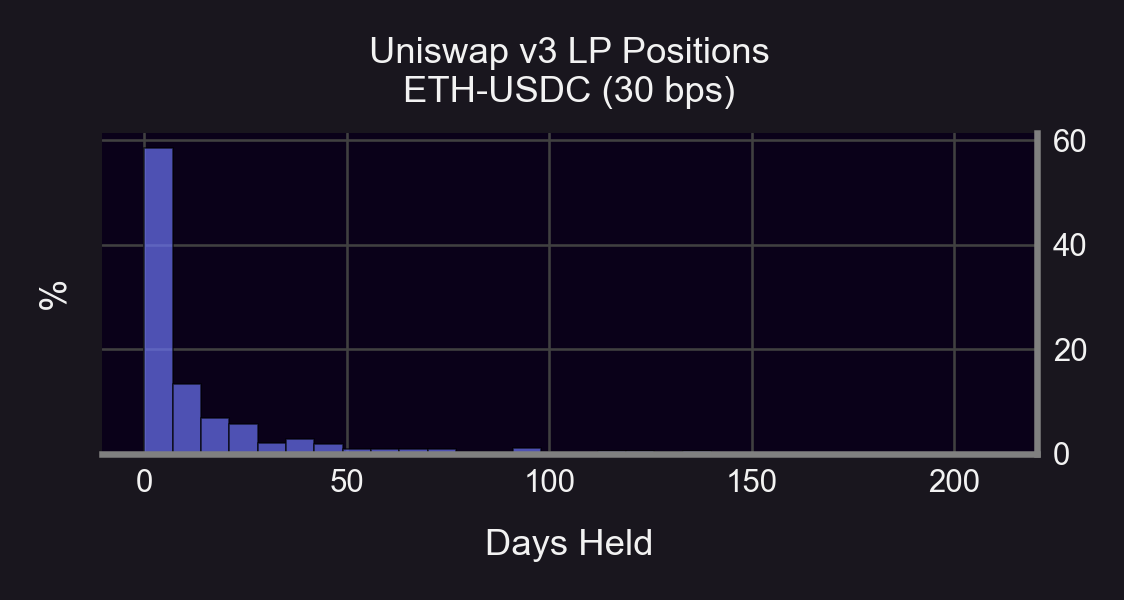

In [17]:
min_val = df.days_held.min()
max_val = df.days_held.max()

bin_edges = np.arange(min_val, max_val + 7, 7)  # +7 to ensure the last bin is included
hist, _ = np.histogram(df.days_held, bins=bin_edges)
hist_percentage = (hist / hist.sum()) * 100

plt.bar(bin_edges[:-1], hist_percentage, width=np.diff(bin_edges), edgecolor='black', alpha=0.7, align='edge')
plt.xlabel('Days Held')
plt.ylabel('%')
plt.title('Uniswap v3 LP Positions\nETH-USDC (30 bps)')

plt.savefig(f"{dir}/days_held_hist", dpi=300)

plt.show()

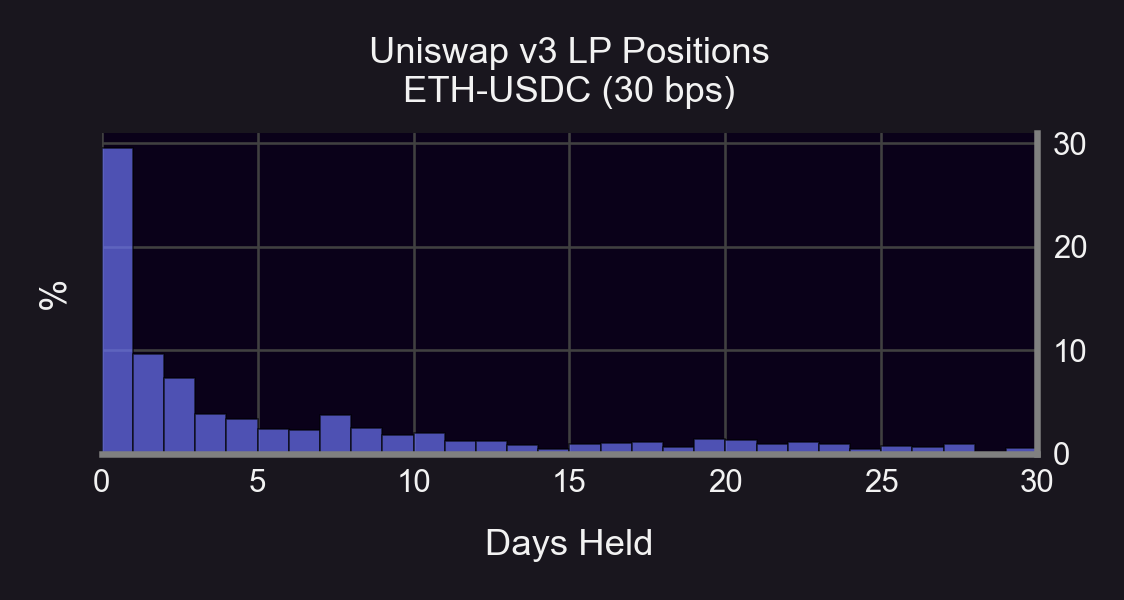

In [18]:
weights = np.ones_like(df.days_held) / len(df.days_held) * 100  # Convert to percentage

plt.hist(df.days_held, bins=np.linspace(0, 30, 31), weights=weights, edgecolor='black', alpha=0.7)
plt.xlabel('Days Held')
plt.ylabel('%')
plt.title('Uniswap v3 LP Positions\nETH-USDC (30 bps)')
plt.xlim(0, 30)

plt.savefig(f"{dir}/days_held_hist_zoom", dpi=300)

plt.show()

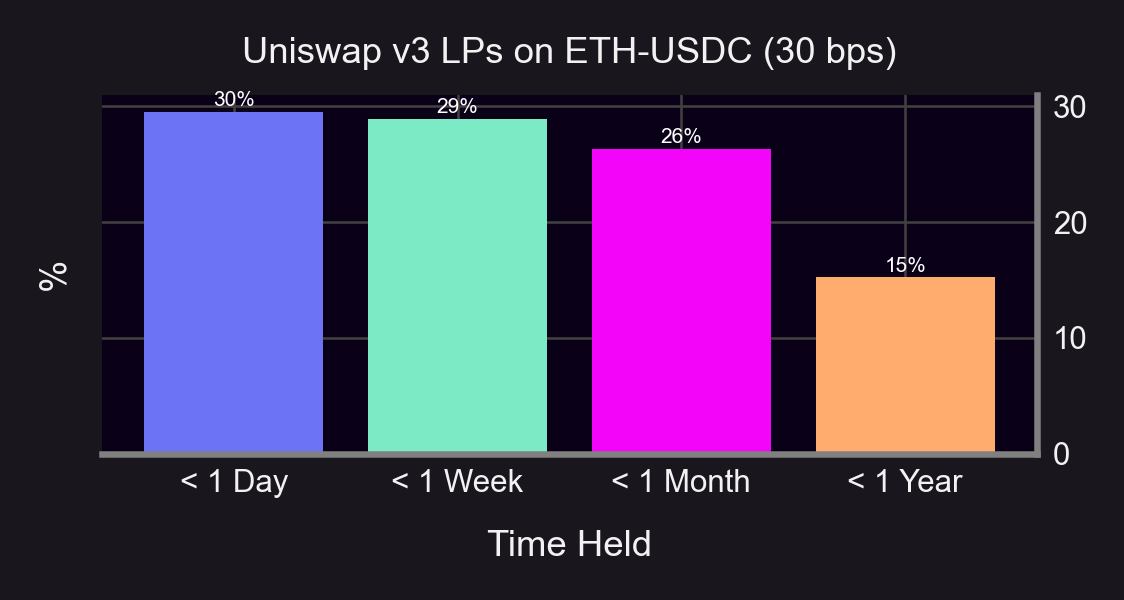

In [19]:
daily = len(df[df['days_held'] <= 1])
weekly = len(df[(df['days_held'] > 1) & (df['days_held'] < 7)])
monthly = len(df[(df['days_held'] > 7) & (df['days_held'] < 30)])
yearly = len(df[df['days_held'] > 30])

labels = ['< 1 Day', '< 1 Week', '< 1 Month', '< 1 Year']
percentages = [100 * period / len(df) for period in [daily, weekly, monthly, yearly]]

bars = plt.bar(labels, percentages, color = ['#6c74f5', '#7ceac5', '#f305f9', '#ffac6e'])

plt.title('Uniswap v3 LPs on ETH-USDC (30 bps)')
plt.xlabel('Time Held')
plt.ylabel('%')

for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{percentage:.0f}%', ha='center', color='white', size=4)

plt.savefig(f"{dir}/comparison_days_held", dpi=300)

plt.show()

In [20]:
def convert_price(p: float, dec_0: int, dec_1: int, inverse_price: bool) -> float:
    """Gets (inverse) price (convenient for pairs like USDC/ETH)
    Inverse price: price of token1 in terms of token0
    Regular price: price of token0 in terms of token1"""
    if inverse_price:
        return 10 ** (dec_1 - dec_0) / p
    else:
        return p / (10 ** (dec_1 - dec_0))

def convert_tick(tick: int, dec_0: int, dec_1: int, inverse_price: bool=False) -> float:
    """Converts tick to price"""
    BASE = 1.0001
    return convert_price(BASE ** tick, dec_0, dec_1, inverse_price)

In [25]:
df['priceLower'] = df.apply(lambda row: convert_tick(row['tickUpper_tickIdx'], row['token0_decimals'], row['token1_decimals'], True), axis=1)
df['priceUpper'] = df.apply(lambda row: convert_tick(row['tickLower_tickIdx'], row['token0_decimals'], row['token1_decimals'], True), axis=1)

def width(priceLower, priceUpper):
    r = np.sqrt(priceUpper / priceLower)
    return r

df['r-value'] = df.apply(lambda row: width(row['priceLower'], row['priceUpper']), axis=1)
df

C:\Users\lybra\AppData\Local\Temp\ipykernel_19692\2130989847.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['priceLower'] = df.apply(lambda row: convert_tick(row['tickUpper_tickIdx'], row['token0_decimals'], row['token1_decimals'], True), axis=1)
C:\Users\lybra\AppData\Local\Temp\ipykernel_19692\2130989847.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['priceUpper'] = df.apply(lambda row: convert_tick(row['tickLower_tickIdx'], row['token0_decimals'], row['token1_decimals'], True), axis=1)
C:

,withdrawnToken0,withdrawnToken1,depositedToken0,depositedToken1,collectedFeesToken1,collectedFeesToken0,id,liquidity,tickLower_tickIdx,tickLower_pool_id,...,timestamp_burn,blockNumber_burn,transaction_id_burn,gasUsed_burn,gasPrice_burn,burns_burn,days_held,priceLower,priceUpper,r-value
31550,0,1.950677240089216494,1716.006466,0.811195084079697317,0,0,459858,0,202680,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,1.678394e+09,16793012.0,0x83b850493ea07ca8fc309c97b7fc8871178703bf630b...,384988.0,6.841079e+10,[{'id': '0x83b850493ea07ca8fc309c97b7fc8871178...,0.267639,1.477398e+03,1.578191e+03,1.033549e+00
31551,2069.999999,0,2070,0,0,0,459881,0,207660,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,1.678539e+09,16804926.0,0x3d308b06987f9df57875498a87a5b35cb9c5564ae7a5...,295794.0,5.065086e+10,[{'id': '0x3d308b06987f9df57875498a87a5b35cb9c...,1.875000,7.774893e+02,9.591614e+02,1.110705e+00
31552,122.009827,0.163479494778240778,199.999544,0.111114858636336191,0,0,459891,0,201540,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,1.678400e+09,16793556.0,0x131054b20513928de44c64468eb76f6168d10395f1e0...,296061.0,4.332661e+10,[{'id': '0x131054b20513928de44c64468eb76f6168d...,0.253056,1.302504e+03,1.768751e+03,1.165316e+00
31553,762.581107,1.541468716953846661,1525.162215,1.02896852454371991,0,0,459904,0,202500,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,1.678399e+09,16793474.0,0x6c639f0dca743d0a9950587f2520ff52fb46af16fd71...,385508.0,5.219868e+10,[{'id': '0x6c639f0dca743d0a9950587f2520ff52fb4...,0.212917,1.451044e+03,1.606854e+03,1.052320e+00
31554,10.28149,0,5,0.003362898272175298,0,0,459915,0,202440,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,1.691299e+09,17853759.0,0xdea4b42a34125a6e2c045c3618d95a223d3671509076...,364984.0,1.285207e+10,[{'id': '0xdea4b42a34125a6e2c045c3618d95a223d3...,149.495139,1.442364e+03,1.616524e+03,1.058653e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34353,2937.192286,1.785511751915750925,2953.242,1.775761743704110573,0,0,575770,0,201660,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,1.696656e+09,18296456.0,0xc094a6e41d68b9f5a897743f6bb6a263e5e8d27f14b9...,363740.0,6.671113e+09,[{'id': '0xc094a6e41d68b9f5a897743f6bb6a263e5e...,0.079306,1.550039e+03,1.747654e+03,1.061833e+00
34357,23058.498779,16.439999999729416766,23058.49878,16.439999999729416767,0,0,575954,0,201960,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,1.696678e+09,18298329.0,0x1da15a75c3ce5366f25097b062d8d59a1a28a70df6f4...,339991.0,5.043058e+09,[{'id': '0x1da15a75c3ce5366f25097b062d8d59a1a2...,0.003333,1.597242e+03,1.696005e+03,1.030453e+00
34362,934.769022,0.579538449892245078,1000,0.539699799005012232,0,0,576123,0,202020,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,1.696730e+09,18302590.0,0xe91b5b9529f7e38e1747406bf55b12dc3440dfb8a099...,394980.0,6.654999e+09,[{'id': '0xe91b5b9529f7e38e1747406bf55b12dc344...,0.323472,1.587688e+03,1.685860e+03,1.030453e+00
34366,570.80204,0.347453222487194395,571.392699,0.347091685875749783,0,0,576203,0,195420,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8,...,1.696747e+09,18304030.0,0xc3b8f331d24a87f226eabab087b7d3581ec62ed23b69...,354184.0,5.997213e+09,[{'id': '0xc3b8f331d24a87f226eabab087b7d3581ec...,0.394583,8.157170e+02,3.261682e+03,1.999636e+00


C:\Users\lybra\AppData\Local\Temp\ipykernel_19692\3924984301.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, color='white')
C:\Users\lybra\AppData\Local\Temp\ipykernel_19692\3924984301.py:68: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


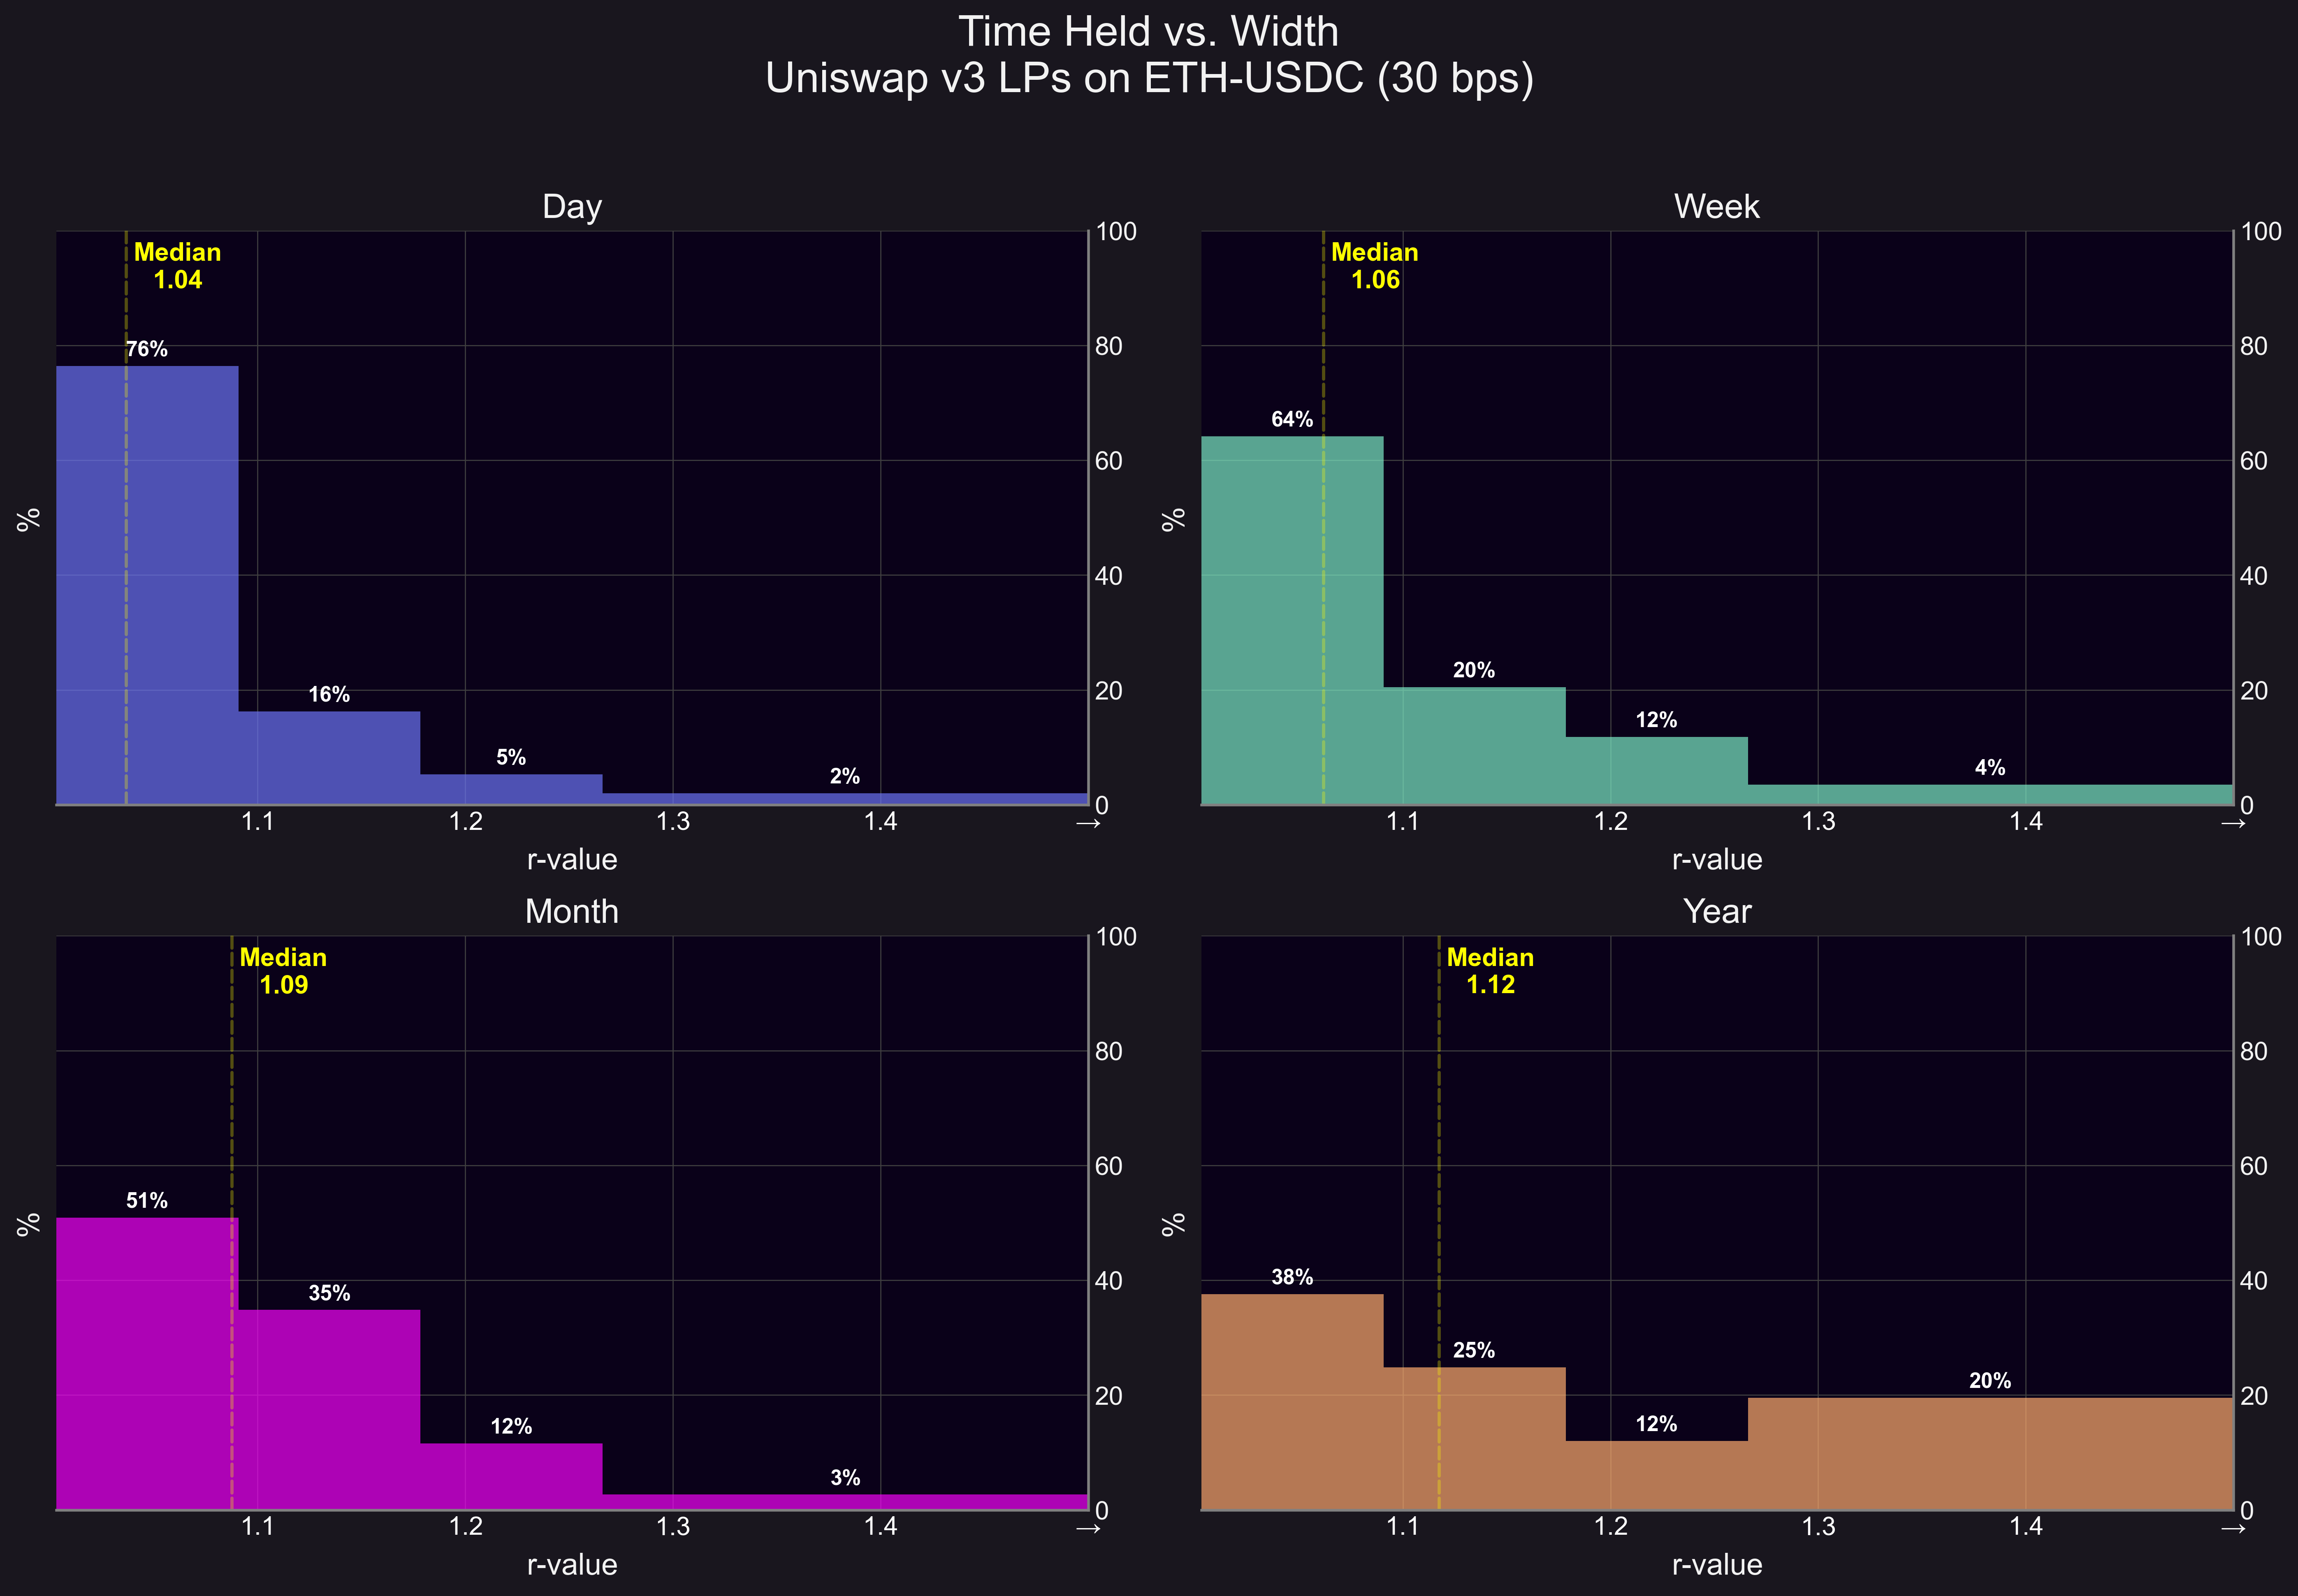

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def filter_upper_outliers(series, factor=1.5):
    """Filter out upper outliers from a Pandas Series using the IQR method with a customizable factor."""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return series[series <= (Q3 + factor * IQR)]

def plot_hist(ax, data, title, color, bins):
    """Plot histogram with percentages."""
    weights = [100 / len(data)] * len(data)
    n, _, patches = ax.hist(data, bins=bins, weights=weights, color=color, alpha=0.7)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    percentages = n
    for count, x in zip(percentages, bin_centers):
        ax.text(x, count + 1, f'{count:.0f}%', color='white', ha='center', va='bottom', fontweight='bold')
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('r-value', fontsize=14)
    ax.set_ylabel('%', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylim(0, 100)
    ax.set_xlim(bins[0], 1.5)

    x_ticks = ax.get_xticks()
    x_labels = [str(tick) for tick in x_ticks]
    if x_ticks[-1] == 1.5:
        x_labels[-1] = '→'
    ax.set_xticklabels(x_labels, color='white')

    median = np.median(data)
    ax.axvline(median, color='yellow', linestyle='dashed', linewidth=1.5, alpha=0.3)
    ax.text(median + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05, ax.get_ylim()[1] * 0.9, 
            f'Median\n{median:.2f}', color='yellow', ha='center', fontsize=12, weight='bold')

# Filter df based on days_held for each bucket
bucket_1 = filter_upper_outliers(df[df['days_held'] <= 1]['r-value'])
bucket_2 = filter_upper_outliers(df[(df['days_held'] > 1) & (df['days_held'] < 7)]['r-value'])
bucket_3 = filter_upper_outliers(df[(df['days_held'] >= 7) & (df['days_held'] < 30)]['r-value'])
bucket_4 = filter_upper_outliers(df[df['days_held'] >= 30]['r-value'])

# Determine the bin edges using bucket_1 and set the last bin's upper edge to np.inf
_, bin_edges = np.histogram(bucket_1, bins=4)
bin_edges[-1] = 1.5

colors = ['#6c74f5', '#7ceac5', '#f305f9', '#ffac6e']

# Plotting
plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 2, 1)
plot_hist(ax1, bucket_1, 'Day', colors[0], bin_edges)

ax2 = plt.subplot(2, 2, 2)
plot_hist(ax2, bucket_2, 'Week', colors[1], bin_edges)

ax3 = plt.subplot(2, 2, 3)
plot_hist(ax3, bucket_3, 'Month', colors[2], bin_edges)

ax4 = plt.subplot(2, 2, 4)
plot_hist(ax4, bucket_4, 'Year', colors[3], bin_edges)

plt.suptitle("Time Held vs. Width\nUniswap v3 LPs on ETH-USDC (30 bps)", fontsize=20, y=1.03)

plt.tight_layout()

plt.savefig(f'{dir}/Time_vs_width.png', dpi=300, bbox_inches='tight')
def save_subplot_as_png(fig, ax, filename):
    """Save a specific subplot (ax) from a figure (fig) as a PNG file."""
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, bbox_inches=extent.expanded(1.1, 1.2))

save_subplot_as_png(plt.gcf(), ax1, f'{dir}/Day.png')
save_subplot_as_png(plt.gcf(), ax2, f'{dir}/Week.png')
save_subplot_as_png(plt.gcf(), ax3, f'{dir}/Month.png')
save_subplot_as_png(plt.gcf(), ax4, f'{dir}/Year.png')

plt.show()

In [27]:
# Thursday, March 9, 2023 14:01:59
earliest_tx_ts = min(df.transaction_timestamp)
earliest_tx_ts

1678370519.0

In [33]:
correlation = df['r-value'].corr(df['days_held'])
correlation

-0.02072354757916508

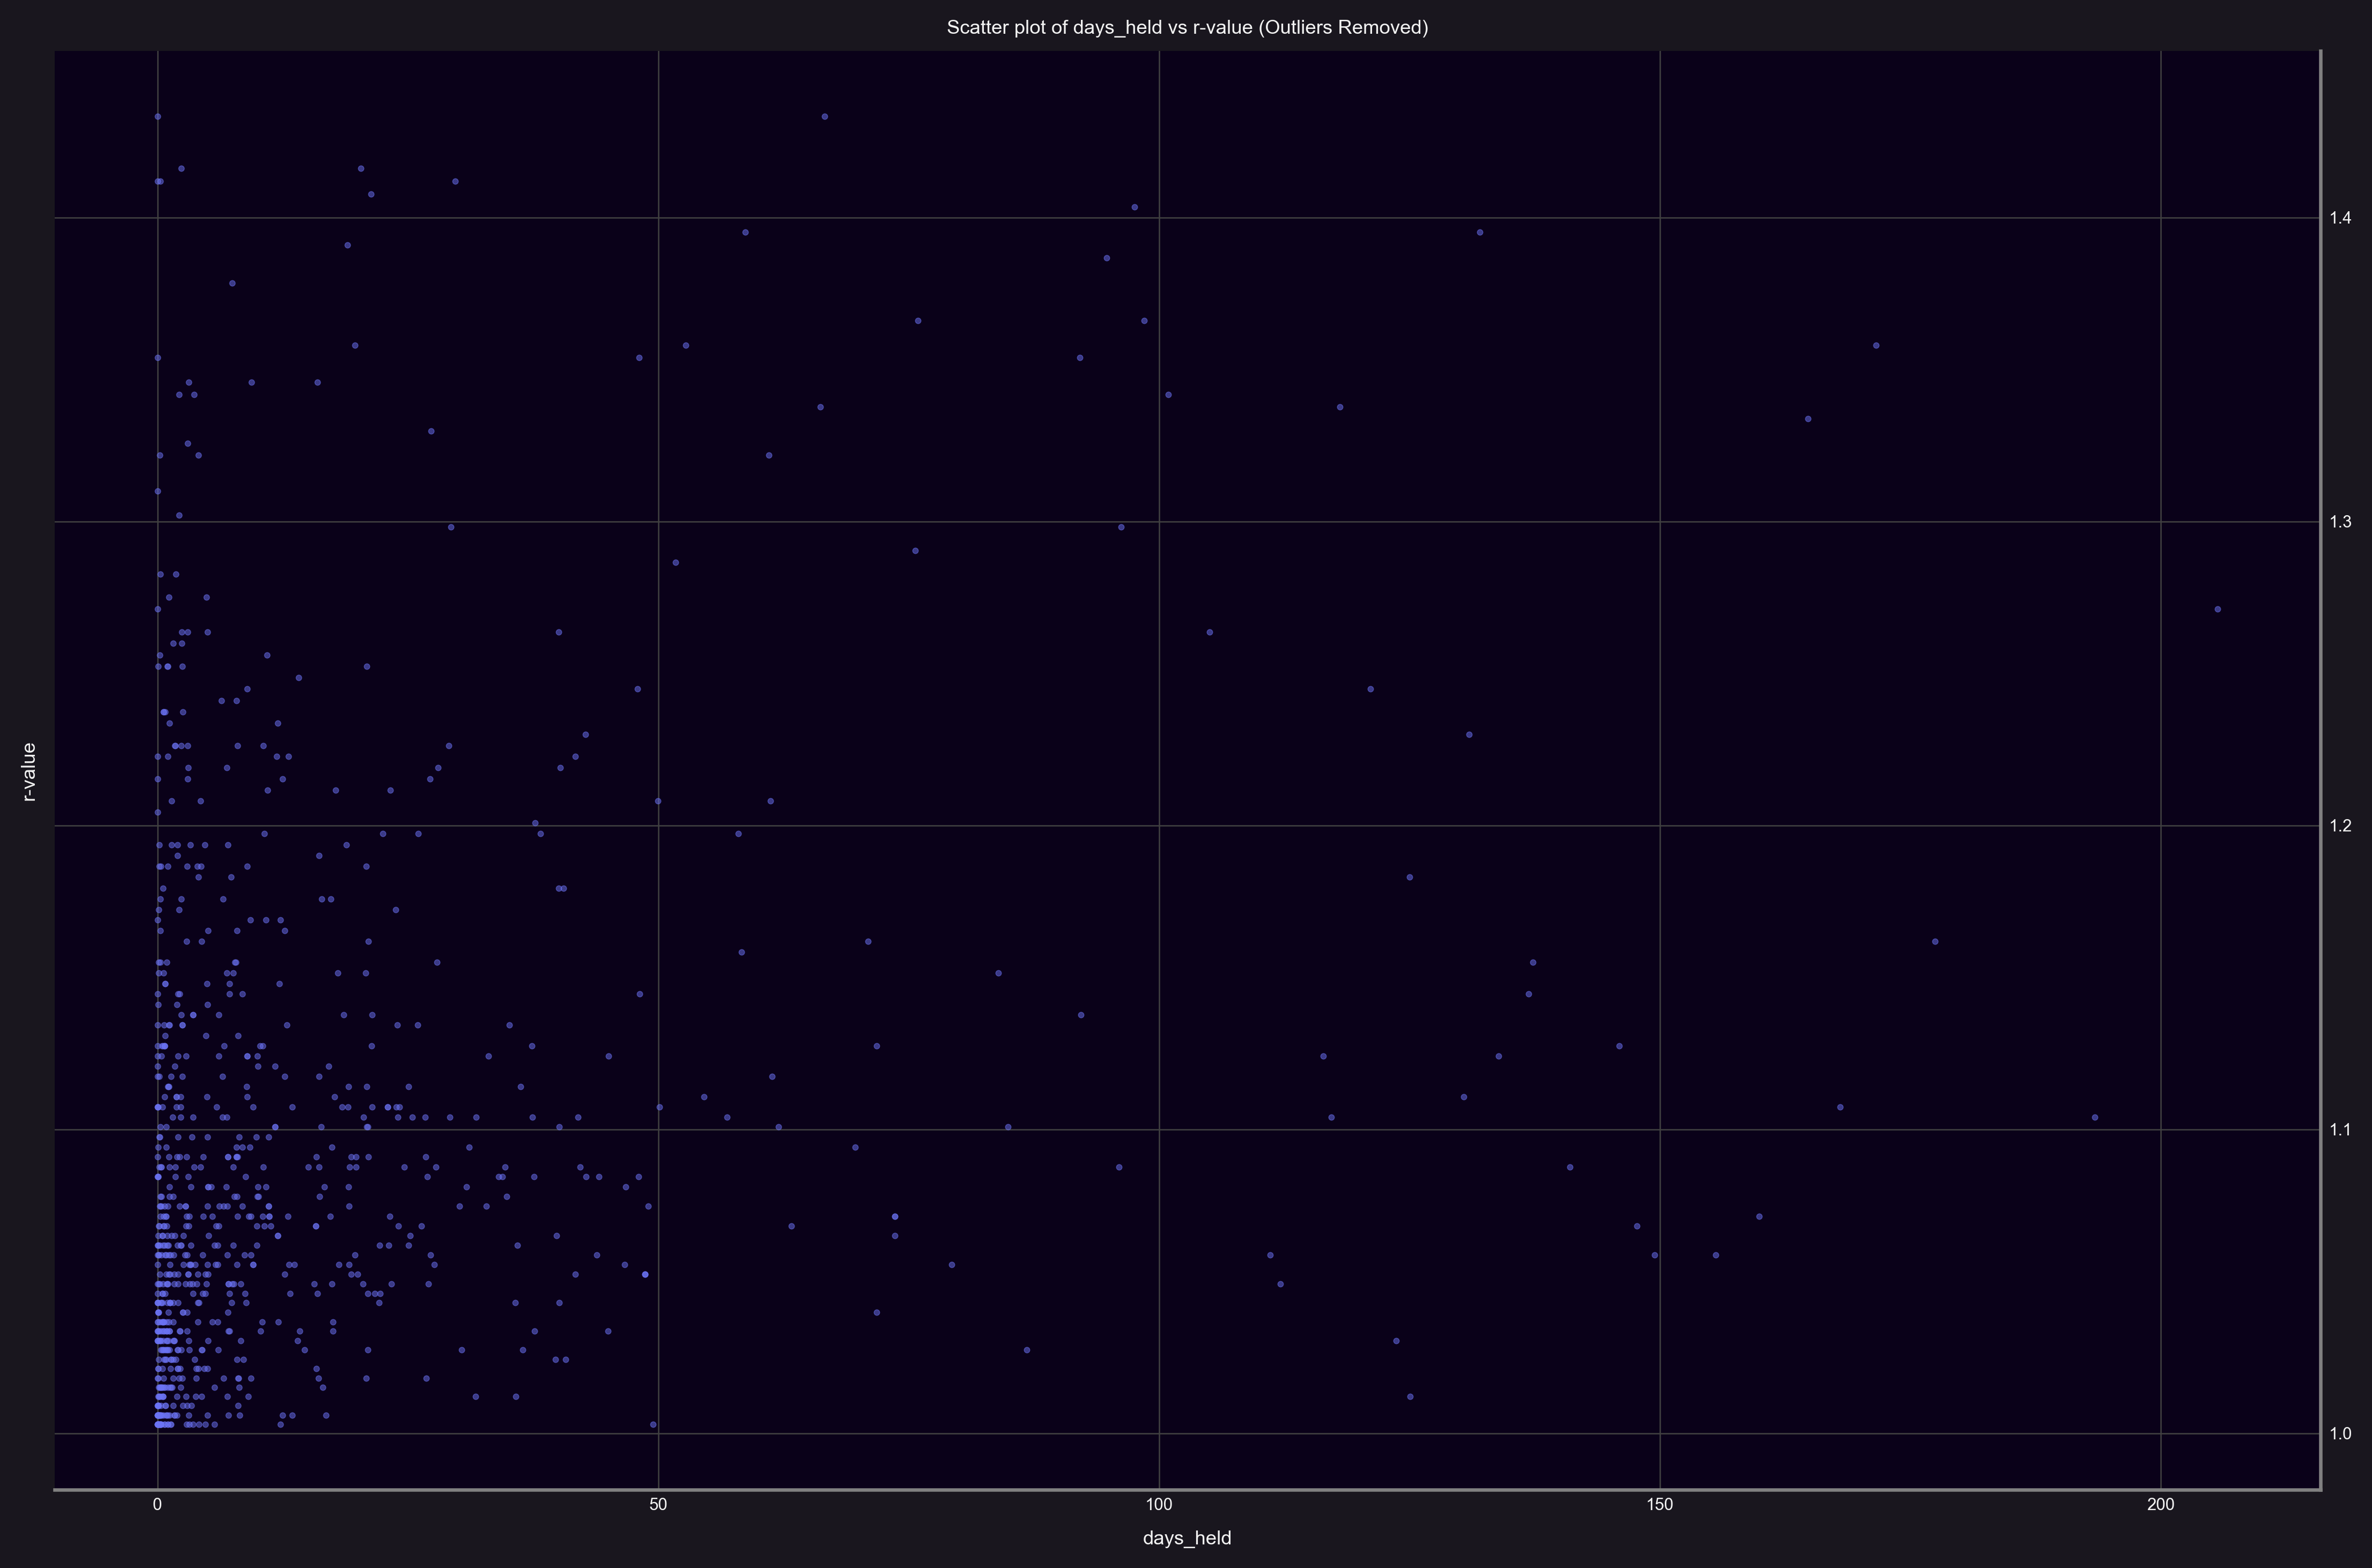

In [42]:
import matplotlib.pyplot as plt

def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 * IQR)]

# Remove outliers
filtered_r_value = remove_outliers(df['r-value'])

# Create a new dataframe with only the rows where both columns are not outliers
filtered_df = df[df['r-value'].isin(filtered_r_value)]

plt.figure(figsize=(12, 8))
plt.scatter(filtered_df['days_held'], filtered_df['r-value'], alpha=0.5)
plt.title('Scatter plot of days_held vs r-value (Outliers Removed)')
plt.xlabel('days_held')
plt.ylabel('r-value')
plt.grid(True)
plt.show()


In [43]:
correlation = filtered_df['r-value'].corr(filtered_df['days_held'])
correlation

0.28139431676673693